# Calculate heatwave duration within data

In [1]:
import iris
import pandas as pd
import xarray as xr
import numpy as np
from dask import array as da

In [2]:
def np_consecutive(arr):
    if isinstance(arr, (xr.DataArray, iris.cube.Cube)):
        data = arr.data
        if isinstance(data, da.Array):
            data.compute_chunk_sizes()
    else:
        data = arr
    out = np.diff(np.where(np.concatenate(([data[0]],
                                     data[:-1] != data[1:],
                                     [True])))[0])[::2]
    return out

In [3]:
def consec_count(data, threshold=25, ndays=14):
    
    days = np.arange(0, ndays+1)
    heatwave_counts = {}
    years = np.unique(data.year)
    for year in years:
        counts = np.zeros_like(days)
        arr = data[data.year==year]
        arr_hot = arr>threshold
        hots = np_consecutive(arr_hot)
        colds = np.count_nonzero(~arr_hot)
        counts[0]=colds
        for day in days[1:-1]:
            counts[day]=np.count_nonzero(hots==day)
        counts[-1]=np.count_nonzero(hots>=days[-1])

        heatwave_counts[year]=counts
    return heatwave_counts

In [4]:
def annual_heatwaves(data, **kwargs):
    if isinstance(data, iris.cube.Cube):
        data = xr.DataArray.from_iris(data).compute()
    ensemble = np.unique(data.ensemble_member)
    dfs = []
    for member in ensemble:
        arr = data.sel(ensemble_member=member).compute()
        counts = consec_count(arr, **kwargs)
        df = pd.DataFrame.from_dict(counts, orient='index')
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'year'}, inplace=True)
        df['ensemble_member']=member
        dfs.append(df)
    return pd.concat(dfs)

In [5]:
def add_decade(df):
    decades = range(1970, 2090, 10)
    labels = [f"{n}s" for n in decades[:-1]]
    return pd.cut(df.year, bins=decades, labels=labels)

## `tasmax`

In [6]:
%%time
fname = "data/UKCP/utci_regional/tasmax_rcp85_land-cpm_uk_london_01-15_day_19801201-20801130.nc"
tasmax = iris.load_cube(fname)
tasmax.summary(shorten=True)

CPU times: user 294 ms, sys: 20.9 ms, total: 315 ms
Wall time: 612 ms


'air_temperature / (degC)            (ensemble_member: 12; time: 21600)'

### Annual number of heatwaves of each duration

In [7]:
%%time
tashw = (annual_heatwaves(tasmax, threshold=28, ndays=90)
         .melt(id_vars=['year', 'ensemble_member'], var_name='duration', value_name='occurances')
         .assign(decade=add_decade)
         .groupby(['decade','duration'])
         .sum()
         .drop(columns=['year', 'ensemble_member'])
         .reset_index()
        )
tashw

CPU times: user 2.03 s, sys: 28.3 ms, total: 2.06 s
Wall time: 2.25 s


,decade,duration,occurances
0,1970s,0,360
1,1970s,1,0
2,1970s,2,0
3,1970s,3,0
4,1970s,4,0
...,...,...,...
996,2070s,86,0
997,2070s,87,0
998,2070s,88,0
999,2070s,89,0


In [8]:
tashw[tashw.duration!=0]

,decade,duration,occurances
1,1970s,1,0
2,1970s,2,0
3,1970s,3,0
4,1970s,4,0
5,1970s,5,0
...,...,...,...
996,2070s,86,0
997,2070s,87,0
998,2070s,88,0
999,2070s,89,0


## `utci`

In [9]:
%%time
fname = "data/UKCP/utci_regional/utcimax_rcp85_land-cpm_uk_london_01-15_day_19801201-20801130.nc"
utci = iris.load_cube(fname)
utci.summary(shorten=True)

CPU times: user 236 ms, sys: 14.8 ms, total: 250 ms
Wall time: 345 ms


'utci / (degC)                       (ensemble_member: 12; time: 21600)'

### Annual number of heatwaves of each duration

In [10]:
%%time
utcihw = (annual_heatwaves(utci, threshold=28, ndays=90)
         .melt(id_vars=['year', 'ensemble_member'], var_name='duration', value_name='occurances')
         .assign(decade=add_decade)
         .groupby(['decade','duration'])
         .sum()
         .drop(columns=['year', 'ensemble_member'])
         .reset_index()
        )
utcihw

CPU times: user 1.95 s, sys: 21.6 ms, total: 1.98 s
Wall time: 2.09 s


,decade,duration,occurances
0,1970s,0,360
1,1970s,1,0
2,1970s,2,0
3,1970s,3,0
4,1970s,4,0
...,...,...,...
996,2070s,86,0
997,2070s,87,0
998,2070s,88,0
999,2070s,89,0


## `utci10`

In [11]:
%%time
fname = "data/UKCP/utci_regional/utci10max_rcp85_land-cpm_uk_london_01-15_day_19801201-20801130.nc"
u10 = iris.load_cube(fname)
u10.summary(shorten=True)

CPU times: user 256 ms, sys: 15.4 ms, total: 272 ms
Wall time: 328 ms


'utci class 10 / (1)                 (ensemble_member: 12; time: 21600)'

### Annual number of heatwaves of each duration

In [12]:
%%time
u10hw = (annual_heatwaves(u10, threshold=6.0, ndays=90)
         .melt(id_vars=['year', 'ensemble_member'], var_name='duration', value_name='occurances')
         .assign(decade=add_decade)
         .groupby(['decade','duration'])
         .sum()
         .drop(columns=['year', 'ensemble_member'])
         .reset_index()
        )
u10hw

CPU times: user 2.14 s, sys: 35.1 ms, total: 2.17 s
Wall time: 2.41 s


,decade,duration,occurances
0,1970s,0,360
1,1970s,1,0
2,1970s,2,0
3,1970s,3,0
4,1970s,4,0
...,...,...,...
996,2070s,86,0
997,2070s,87,0
998,2070s,88,0
999,2070s,89,0


# Poisson plotting

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson

def fit_poisson(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)

In [14]:
def poisson_fit_plot(data, title=""):
    x = data.duration
    y = data.occurances
    n = data.occurances.sum()

    lamb, _ = curve_fit(fit_poisson, x, y/n)

    plt.plot(
            x,
            n*fit_poisson(x, lamb),
            marker='o',
            color='red',
            label='Poisson Fit',
        )
    
    plt.bar(
            x,
            y,
            color='green',
            label='Data'
        )

    plt.title(title)
    plt.legend()
    plt.yscale('log')
    plt.ylim(0.5, 1e5)
    plt.xlim(-2, 32)
#     plt.annotate(f"lambda = {lamb[0]:.4f}", (20, 1e3), size=16)
    plt.show()

In [15]:
def plots(df, decades=['1980s', '1990s', '2020s', '2030s', '2060s', '2070s'], title=""):
    for decade in decades:
        poisson_fit_plot(df[df.decade==decade], title=f"{title}{decade}")

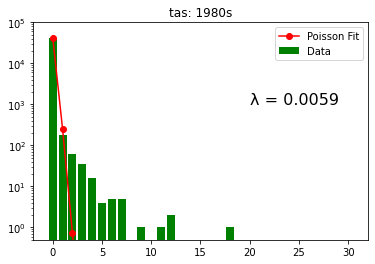

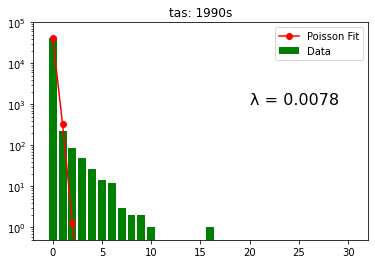

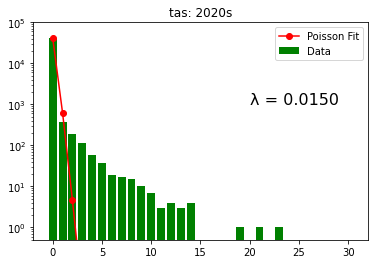

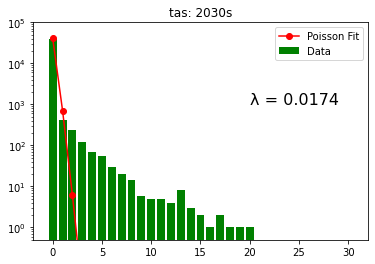

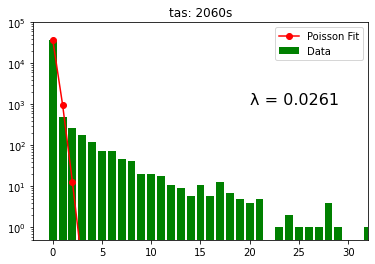

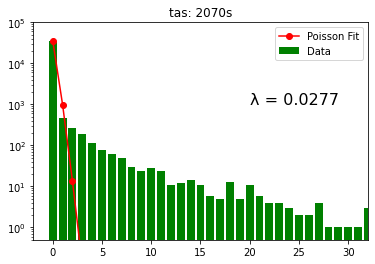

In [37]:
plots(tashw, title='tas: ')

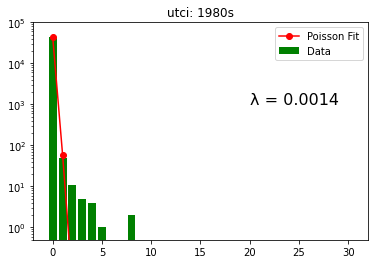

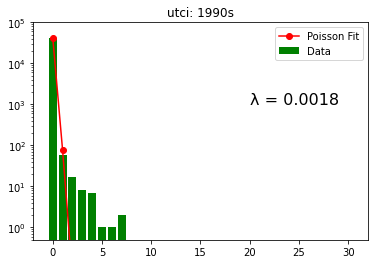

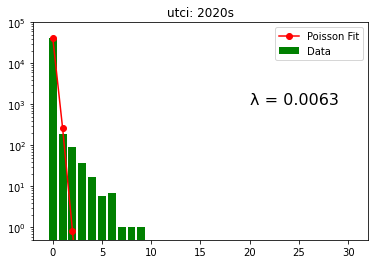

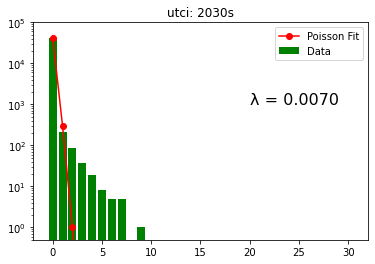

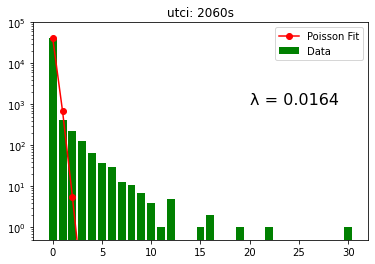

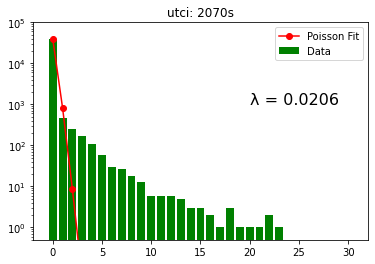

In [83]:
plots(utcihw, title='utci: ')

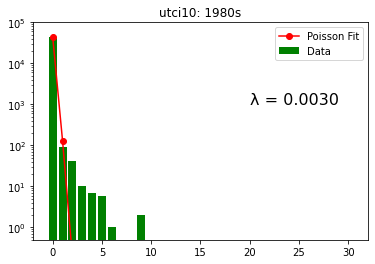

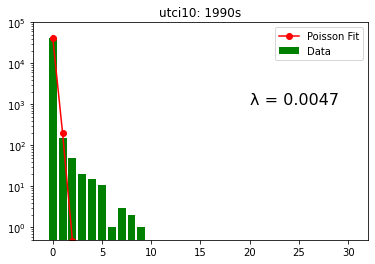

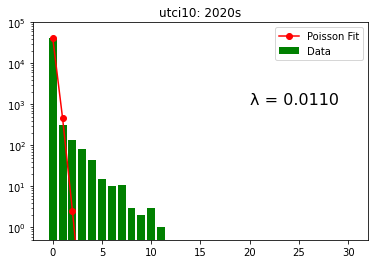

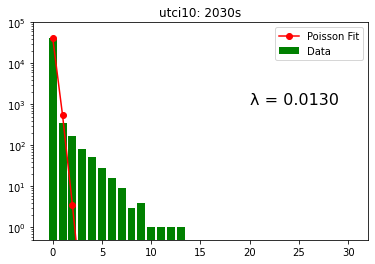

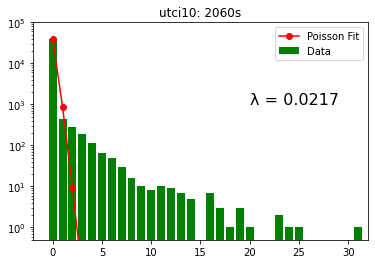

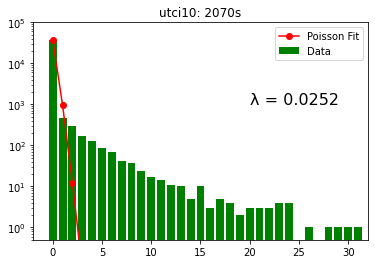

In [84]:
plots(u10hw, title='utci10: ')

# Export figures
#### Timo Denk has a good tutorial on this: https://timodenk.com/blog/exporting-matplotlib-plots-to-latex/
Although in the end I used .pdf instead of .pgf

In [178]:
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [262]:
def poisson_fit_ax(data, ax, title=""):
    x = data.duration
    y = data.occurances
    n = data.occurances.sum()

    lamb, _ = curve_fit(fit_poisson, x, y/n)
    
    lhw = int(longest_hw(data).duration)

    ax.plot(
            x,
            n*fit_poisson(x, lamb),
            markersize=2,
            marker='o',
            color='darkgreen',
            label='Poisson Fit',
        )
    
    ax.bar(
            x,
            y,
            label='Data',
            color='deepskyblue'
        )

    ax.set_title(title)
    ax.text(19.5, 5e4, f'$\lambda$ = {lamb[0]:.4f}', ha='left', va='center', fontsize='small')
    ax.text(19.5, 2e4, f'L = {lhw} days', ha='left', va='center', fontsize='small')
    ax.grid(axis='y')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_axisbelow(True)
    ax.semilogy()
    ax.set_ylim(0.5, 1e5)
    ax.set_xlim(-2, 32)


In [263]:
def longest_hw(df):
    return df.loc[df.occurances!=0].loc[df.duration==df[df.occurances!=0].duration.max()]

In [264]:
def decade_plot(df, fname, title):
    width=8.50166
    fsize=(width, 2*width/3)

    fig, axs = plt.subplots(2,3, sharex=True, sharey=False, figsize=fsize)

    fig.suptitle(title, x=0.1, y=0.96, ha='left')
    fig.text(0.51, 0.06, 'Heatwave duration (days)', ha='center', va='center')
    fig.text(0.07, 0.5, 'Number of occurances', ha='center', va='center', rotation='vertical')

    decades=['1980s', '2020s', '2060s', '1990s', '2030s', '2070s']
    for i in range(6):
        ax = axs.flatten()[i]
        decade = decades[i]
        poisson_fit_ax(df[df.decade==decade], ax, title=f"{decade}")
        if i == 2: 
            ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.15), ncol=2,
                borderaxespad=0, frameon=False, fontsize='small')

    plt.savefig(f"pngs/{fname}.png", bbox_inches='tight')
    plt.savefig(f"pdfs/{fname}.pdf", bbox_inches='tight')
    plt.savefig(f"pgfs/{fname}.pgf", bbox_inches='tight')

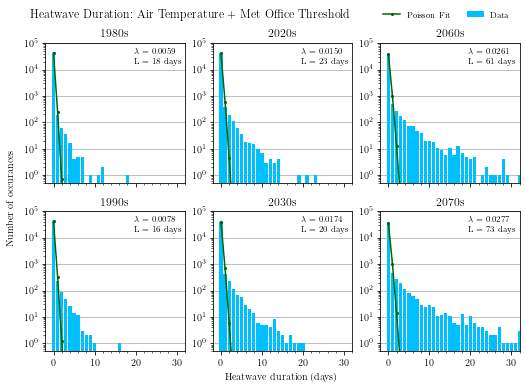

In [265]:
decade_plot(tashw, fname='tas_poisson', title='Heatwave Duration: Air Temperature + Met Office Threshold')

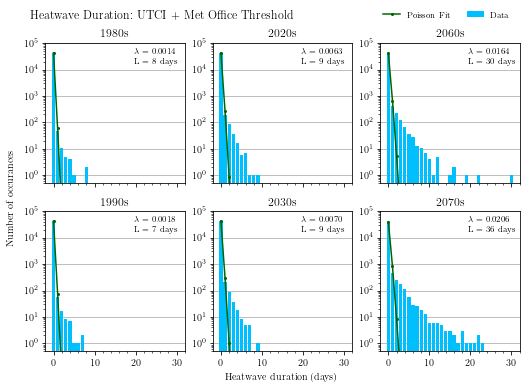

In [266]:
decade_plot(utcihw, fname='utci_poisson', title='Heatwave Duration: UTCI + Met Office Threshold')

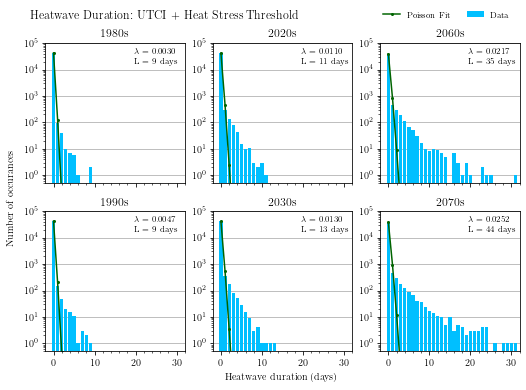

In [267]:
decade_plot(u10hw, fname='u10_poisson', title='Heatwave Duration: UTCI + Heat Stress Threshold')